In [44]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import datetime as dt 
import matplotlib.pyplot as plt

In [45]:
gas_hr = pd.read_csv('./csv/hourly_readings_final.csv');

# Remove 2 id as the have less than 3 readings
gas_hr=gas_hr[gas_hr.dataid!=6101]
gas_hr=gas_hr[gas_hr.dataid!=9620]

In [46]:
# Remap time to hour with reference to 0 instead of date
gas_hr.localminute = pd.to_datetime(gas_hr.localminute, infer_datetime_format = True,format = "%Y/%m/%d %I:%M:%S %p");
ori_gas_hr=gas_hr;
min_time=min(gas_hr['localminute']);
gas_hr.localminute=gas_hr.localminute.map(lambda x: (x-min_time).total_seconds()/3600.0);
gas_hr.localminute

0            0.0
1            1.0
2            2.0
3            3.0
4            4.0
5            5.0
6            6.0
7            7.0
8            8.0
9            9.0
10          10.0
11          11.0
12          12.0
13          13.0
14          14.0
15          15.0
16          16.0
17          17.0
18          18.0
19          19.0
20          20.0
21          21.0
22          22.0
23          23.0
24          24.0
25          25.0
26          26.0
27          27.0
28          28.0
29          29.0
           ...  
600960    4350.0
600961    4351.0
600962    4352.0
600963    4353.0
600964    4354.0
600965    4355.0
600966    4356.0
600967    4357.0
600968    4358.0
600969    4359.0
600970    4360.0
600971    4361.0
600972    4362.0
600973    4363.0
600974    4364.0
600975    4365.0
600976    4366.0
600977    4367.0
600978    4368.0
600979    4369.0
600980    4370.0
600981    4371.0
600982    4372.0
600983    4373.0
600984    4374.0
600985    4375.0
600986    4376.0
600987    4377

In [47]:
id_list=gas_hr['dataid'].unique()

In [48]:
# Remap each household's consumption with reference to 0 instead of cumalative reading from before
normed_gas_hr=pd.DataFrame();
for _id in id_list:
    gas_temp=gas_hr[gas_hr['dataid']==_id];
    min_consumption=min(gas_temp['meter_value']);
    gas_temp['meter_value']=gas_temp.meter_value.map(lambda x: x-min_consumption);
    normed_gas_hr=normed_gas_hr.append(gas_temp);


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [49]:
# Find id the lacks data
id_lack=[]
length=[]
id_list1=[35];
for _id in id_list:
    gas_hr_id=gas_hr[gas_hr['dataid']==_id];
    length.append(len(gas_hr_id))
for index, item in enumerate(length):
    if((item<2000) & (item>100)):
        id_lack.append(id_list[index]);
id_lack

[1403, 2755, 2814, 2946, 3036, 4671, 5317, 5545, 6673, 7566, 8244, 9160, 9600]

In [50]:
# Find id that have similar reading with those in with current id
# Loop through list of id that lacks data 

id_lack1=[4671];
soft_margin=0.2;
threshold=0.9;
normed_gas_hr_cp=pd.DataFrame(columns=['localminute','dataid','meter_value'])
for _id in id_lack:
    gas_lack_hr=normed_gas_hr[normed_gas_hr['dataid']==_id];
    time_min=min(gas_lack_hr['localminute']);
    time_max=max(gas_lack_hr['localminute']);
    gas_compensate=normed_gas_hr[(normed_gas_hr['localminute']>=time_min) & (normed_gas_hr['localminute']<=time_max) 
                         &(normed_gas_hr['dataid']!=_id)];
    id_com=gas_compensate['dataid'].unique();
    
    for c_id in id_com:
        gas_cid=pd.DataFrame();
        gas_cid=gas_compensate[gas_compensate['dataid']==c_id];
        #c_diff=gas_cid['meter_value'].diff();
        min_consumption=min(gas_cid['meter_value']);
        gas_cid['meter_value']=gas_cid.meter_value.map(lambda x: x-min_consumption);
        gas_cid.reset_index(drop=True,inplace=True);
        
        time_min_c=min(gas_cid['localminute']);
        time_max_c=max(gas_cid['localminute']);
        gas_lack_c=pd.DataFrame();
        gas_lack_c=gas_lack_hr[(gas_lack_hr['localminute']>=time_min_c) & (gas_lack_hr['localminute']<=time_max_c)];
        #ori_diff=gas_lack_c['meter_value'].diff();
        min_consumption=min(gas_lack_c['meter_value']);
        gas_lack_c['meter_value']=gas_lack_c.meter_value.map(lambda x: x-min_consumption);
        gas_lack_c.reset_index(drop=True,inplace=True);
        
        diff_percent=gas_cid['meter_value']/gas_lack_c['meter_value'];
        equal_num=len(diff_percent[(diff_percent<=(1+soft_margin))&
                                   (diff_percent>=(1-soft_margin))])+len(diff_percent[np.isnan(diff_percent)]);
        if(equal_num>=threshold*len(gas_cid)):
            gas_cid.dataid=gas_cid.dataid.replace(c_id,_id);
            if(time_min_c!=time_min):
                temp_reading=gas_lack_hr[gas_lack_hr['localminute']==time_min_c]['meter_value'].values;
                extra_reading=temp_reading[0];
                gas_cid['meter_value']=gas_cid.meter_value.map(lambda x: x+extra_reading);
            normed_gas_hr_cp=normed_gas_hr_cp.append(gas_cid);           

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#ind

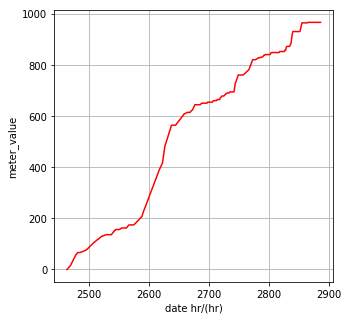

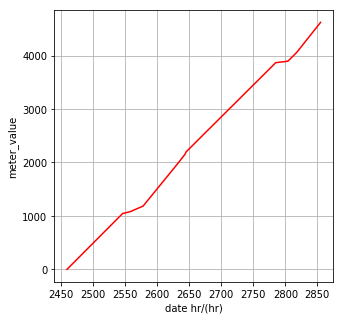

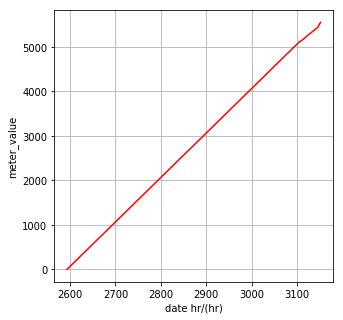

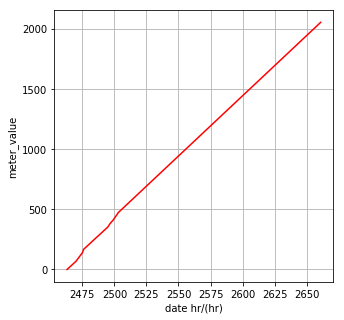

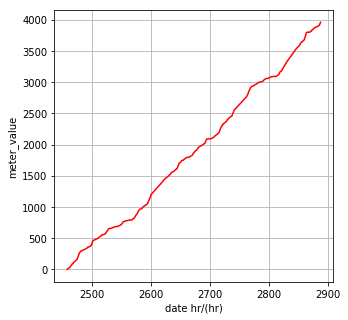

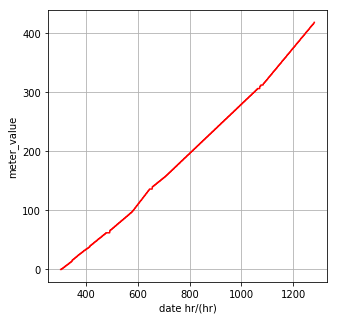

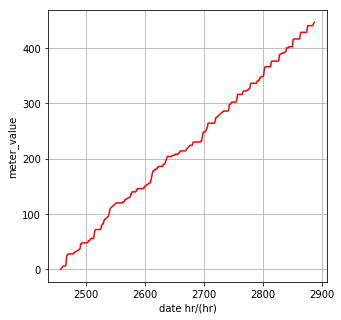

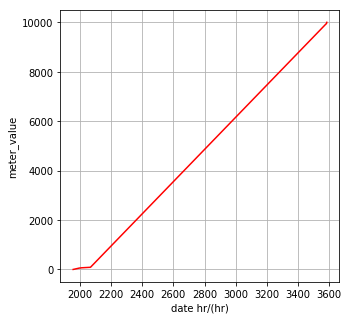

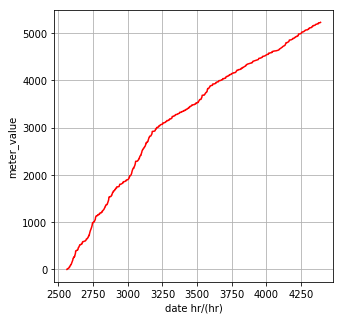

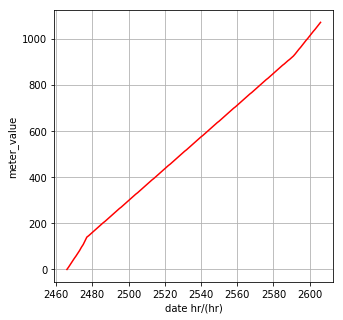

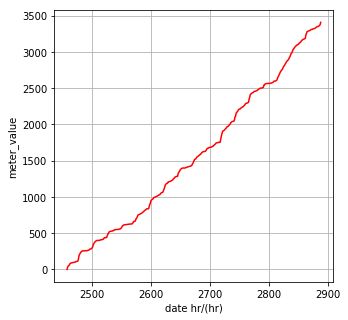

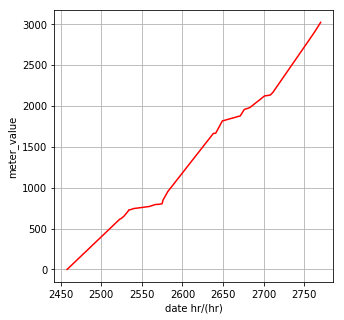

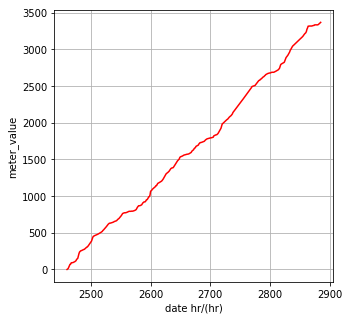

In [51]:
for _id in id_lack:
    temp=normed_gas_hr[normed_gas_hr['dataid']==_id]
    temp.reset_index(drop=True,inplace=True)
    fig=plt.figure(figsize=(5,5));
    plt.plot(temp.localminute,temp.meter_value,'r');
    plt.xlabel('date hr/(hr)');
    plt.ylabel('meter_value'),
    plt.grid();
    plt.show();

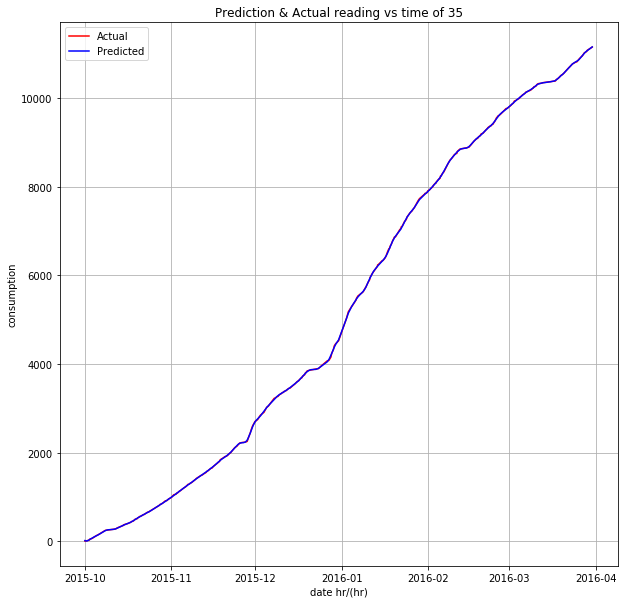

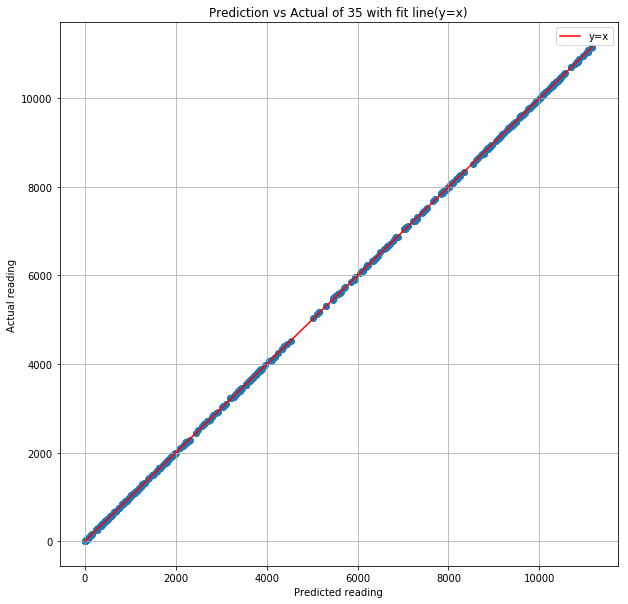

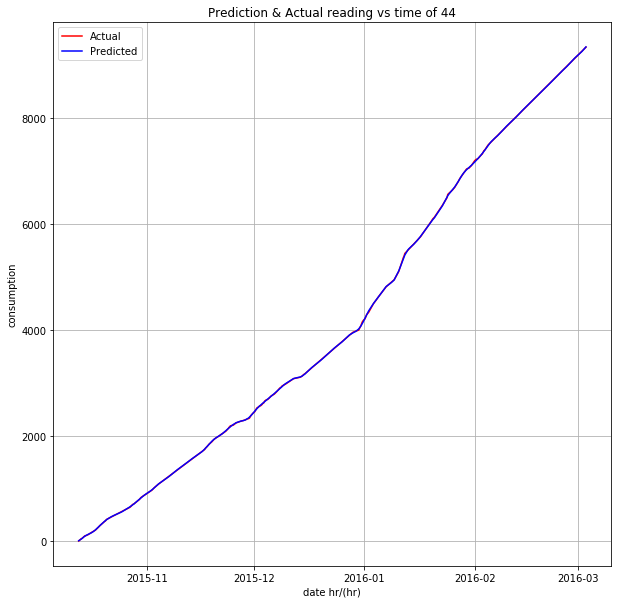

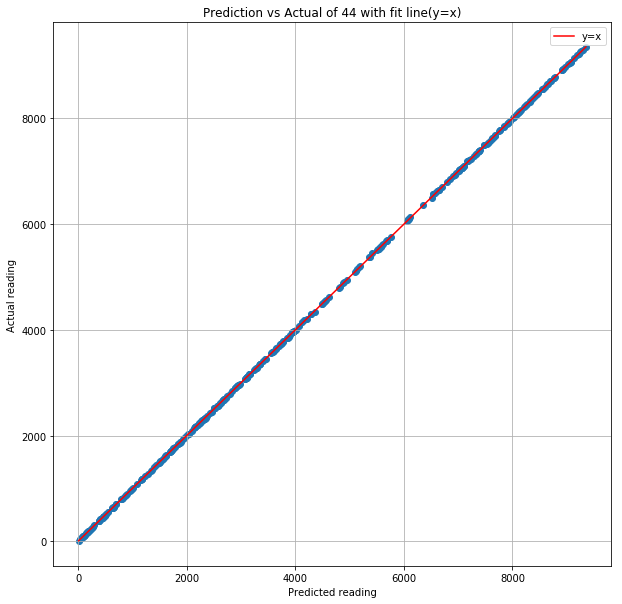

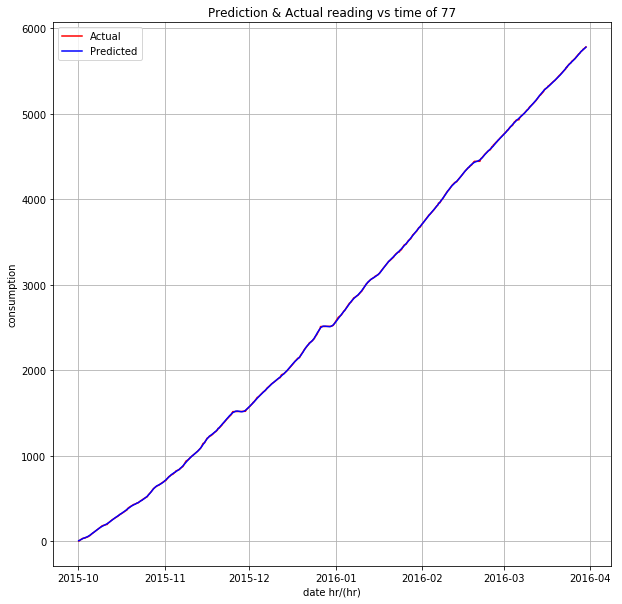

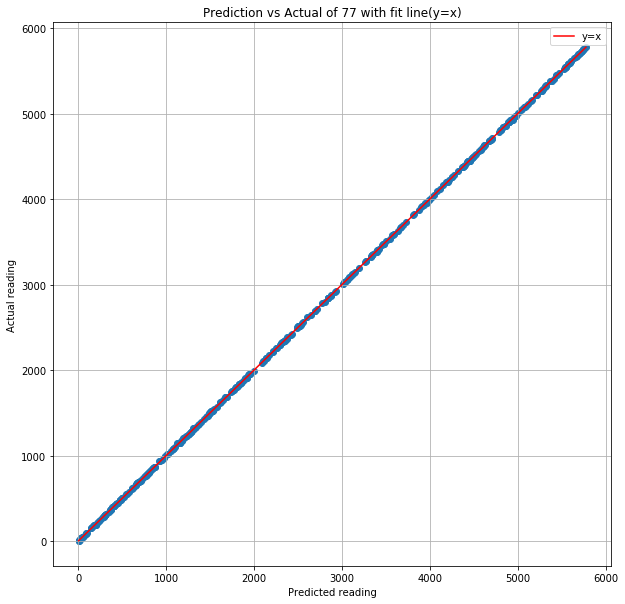

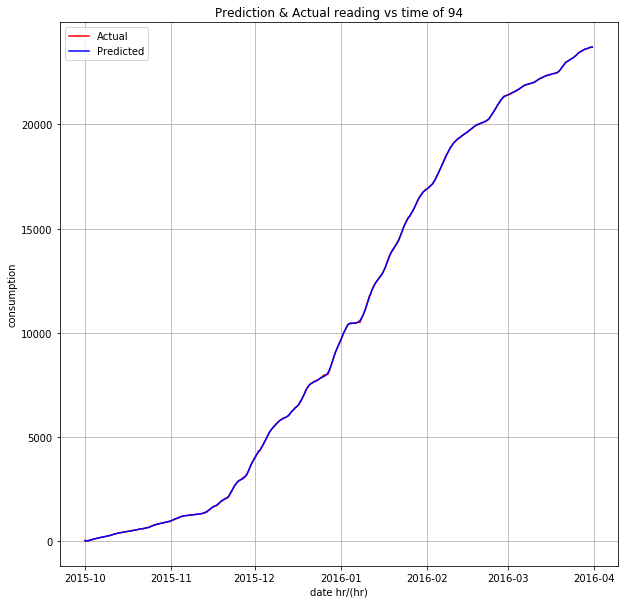

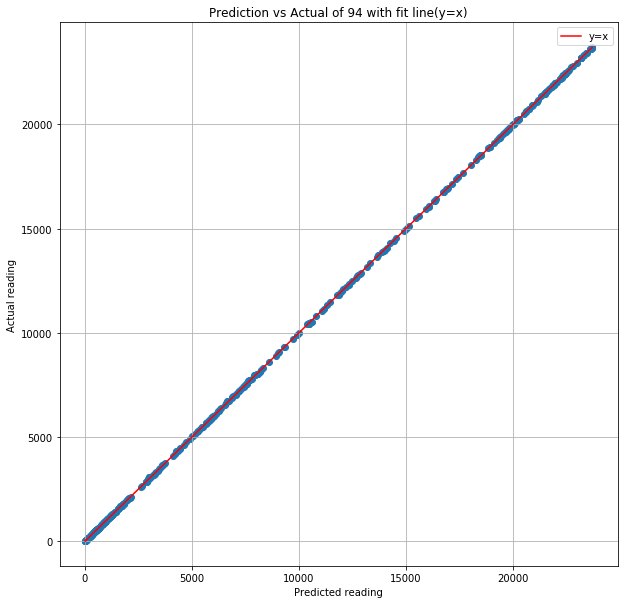

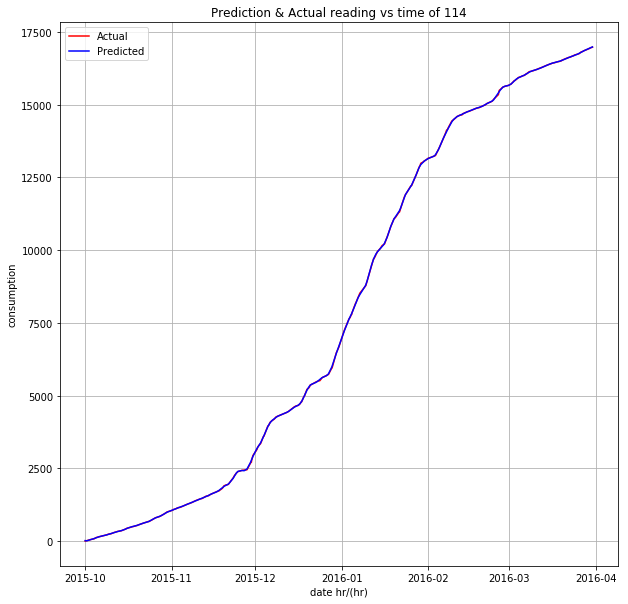

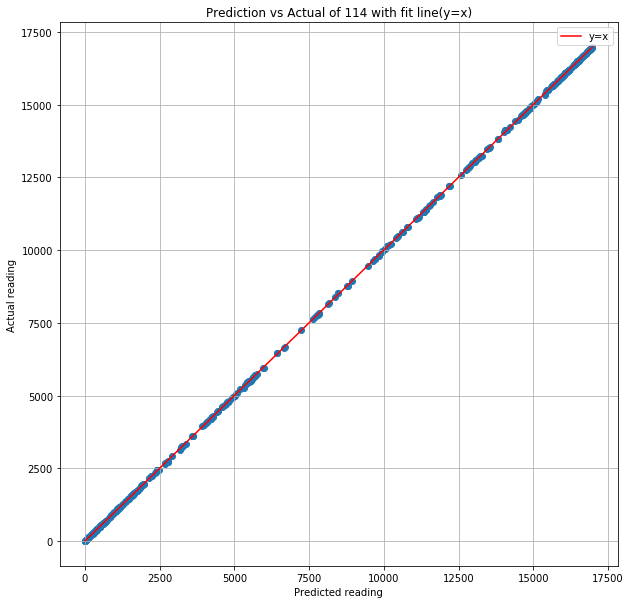

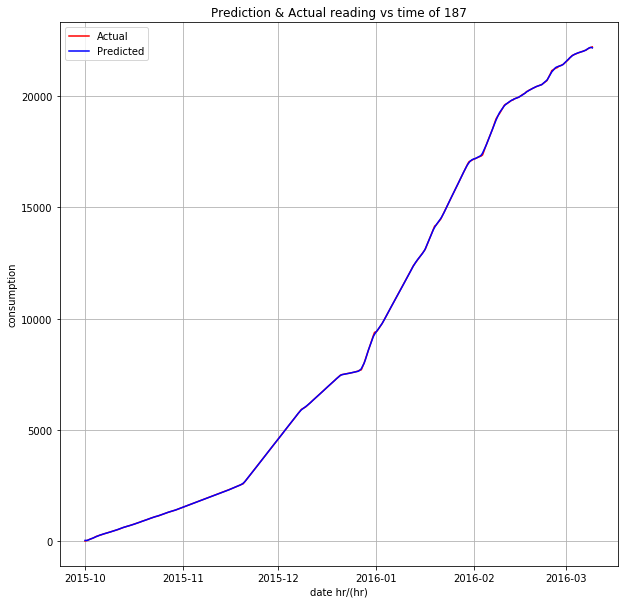

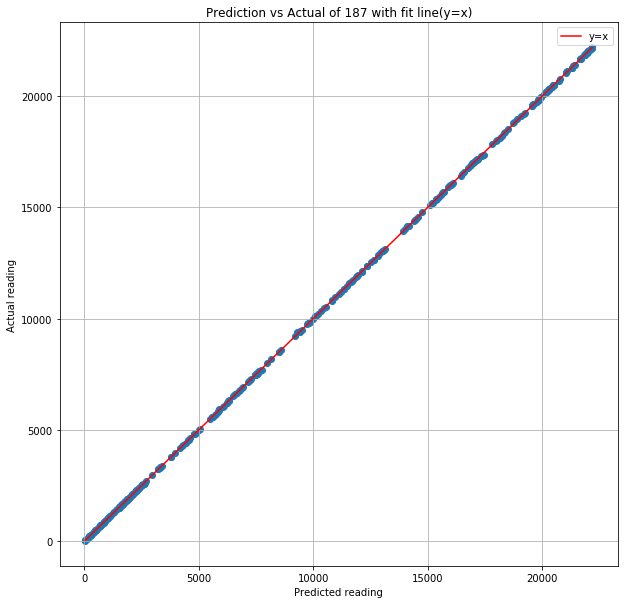

KeyboardInterrupt: 

In [57]:
P_array=[];
score=[];
decre_index=0;
id_list1=[35]

for index,item in enumerate(id_list):
    
    # get normalised gas reading and meter value of a single id 
    X_temp=normed_gas_hr[normed_gas_hr['dataid']==item][['localminute']];
    Y_temp=normed_gas_hr[normed_gas_hr['dataid']==item][['meter_value']];
    
    # Test train split for the data obtained.
    # If the id lacks data, split 50/50, else 90/10
    if(item in id_lack):
        (X_train, X_test, Y_train, Y_test)=train_test_split(X_temp,Y_temp,test_size=0.5, random_state = 10);
    else:
        (X_train, X_test, Y_train, Y_test)=train_test_split(X_temp,Y_temp,test_size=0.1, random_state = 10);
    
    # For those id that lacked data, add more data from id with similar trend
    if(item in id_lack):
        X_train=X_train.append(normed_gas_hr_cp[normed_gas_hr_cp['dataid']==item][['localminute']]);
        Y_train=Y_train.append(normed_gas_hr_cp[normed_gas_hr_cp['dataid']==item][['meter_value']]);
       
    # Reshape Y
    Y_train = Y_train.meter_value.ravel()
    Y_test = Y_test.meter_value.ravel()
     
        
    # Train a model for the id and plot the predicted model with actual model
    if(len(X_temp)<10):
        P_array.append('not enough data');
        score.append('not enough data')
    else:
        LR=SVR(C=10000, epsilon = 5, gamma=0.0001)
#         LR = SVR(C = 3500, epsilon = 20, gamma = 1e-5)
        predictor=LR.fit(X_train,Y_train);
        P_array.append(predictor)
        score.append(P_array[index].score(X_test,Y_test));
        predicted=P_array[index].predict(X_test);

        X_test=X_test.localminute.map(lambda x: dt.timedelta(hours=x)+min_time);
        result=pd.DataFrame(columns=['localminute','actual_reading','predicted_reading']);
        result['localminute']=X_test;
        result['actual_reading']=Y_test;
        result['predicted_reading']=predicted;
        result=result.sort_values(by='localminute');
        fig=plt.figure(figsize=(10,10));
        t='Prediction & Actual reading vs time of '+str(item)
        plt.plot(result.localminute,result.actual_reading,'r',label='Actual');
        plt.plot(result.localminute,result.predicted_reading,'b',label='Predicted');
        plt.legend()
        plt.xlabel('date hr/(hr)');
        plt.ylabel('consumption');
        plt.title(t,loc='center');
        plt.grid();
        plt.show();
        fig=plt.figure(figsize=(10,10));
        t='Prediction vs Actual of '+str(item)+' with fit line(y=x)'
        plt.scatter(result.predicted_reading.tolist(),result.actual_reading.tolist());
        plt.plot(result.predicted_reading,result.predicted_reading,'r',label='y=x')
        plt.legend();
        plt.xlabel('Predicted reading');
        plt.ylabel('Actual reading');
        plt.title(t,loc='center');
        plt.grid();
        plt.show();

In [56]:
# parameters = [{'kernel': ['rbf'],'gamma': [1e-5, 1e-6, 1e-7], 'C': [2500, 3000, 3500], 'epsilon' : [20, 50, 100]}]

parameters = [{'kernel': ['rbf'],'gamma': [1e-4, 1e-5, 1e-6], 'C': [3500, 5000, 10000], 'epsilon' : [5, 10, 20, 50]}]

# 5-fold cross validation

clf = GridSearchCV(SVR(), parameters, cv=5)
clf.fit(X_train, Y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on training set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
print()


Best parameters set found on development set:

{'C': 10000, 'epsilon': 5, 'gamma': 0.0001, 'kernel': 'rbf'}

Grid scores on training set:

1.000 (+/-0.000) for {'C': 3500, 'epsilon': 5, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 5, 'gamma': 1e-05, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 5, 'gamma': 1e-06, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 10, 'gamma': 1e-06, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 20, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 20, 'gamma': 1e-05, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 20, 'gamma': 1e-06, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 50, 'gamma': 0.0001, 'kernel': 'rbf'}
1.000 (+/-0.000) for {'C': 3500, 'epsilon': 50, 'g